In [1]:
%load_ext autoreload
%autoreload 1

%aimport dataset_processing
import pandas as pd
import numpy as np

training_path = "data/training_dataset.csv"
evaluation_path = "data/evaluation_dataset.csv"
final_evaluation_path = "data/final_evaluation_dataset.csv"


### Test how different interval lengths and number of interval affect performance on training set

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


#values_interval_length = [1,2,3,4,5,6,7,8,9,10]
values_interval_length = [3]
#values_num_past_intervals = [1,5,10,15,20,25,30]
values_num_past_intervals = [5,15]

results_df = pd.DataFrame(columns=["interval_length", "num_past_intervals", 
                                   "Train RMSE", "Train MAE", "Train MAPE", "Train R^2",
                                   "Test RMSE", "Test MAE", "Test MAPE", "Test R^2"])

for interval_length in values_interval_length:
    for num_past_intervals in values_num_past_intervals:
        train_df = dataset_processing.generate_dataset(training_path, num_past_intervals=num_past_intervals,
                                                        interval_length=interval_length, num_timesteps_whole_network = 0,
                                                        exclude_zero_flows = True)
        train_features = train_df.filter(like="flow_prev").columns.to_list()
        target = "flow_next_15min"

        X_train = train_df[train_df["datetime"].dt.day >= 10][train_features].to_numpy()
        y_train = train_df[train_df["datetime"].dt.day >= 10][target].to_numpy()

        X_test = train_df[train_df["datetime"].dt.day < 10][train_features].to_numpy()
        y_test = train_df[train_df["datetime"].dt.day < 10][target].to_numpy()


        linear_model = LinearRegression(fit_intercept=False)
        linear_model.fit(X_train, y_train)

        y_pred = linear_model.predict(X_train)
        rmse_train = root_mean_squared_error(y_train, y_pred)
        mae_train = mean_absolute_error(y_train, y_pred)
        mape_train = mean_absolute_percentage_error(y_train, y_pred)
        r2_train = r2_score(y_train, y_pred)

        y_pred = linear_model.predict(X_test)
        rmse_test = root_mean_squared_error(y_test, y_pred)
        mae_test = mean_absolute_error(y_test, y_pred)
        mape_test = mean_absolute_percentage_error(y_test, y_pred)
        r2_test = r2_score(y_test, y_pred)

        it_df = pd.DataFrame(data={"interval_length": interval_length,"num_past_intervals": num_past_intervals,
                                    "Train RMSE": rmse_train, "Train MAE": mae_train, "Train MAPE": mape_train,"Train R^2": r2_train,
                                    "Test RMSE": rmse_test, "Test MAE": mae_test,  "Test MAPE": mape_test,"Test R^2":r2_test}, index=[0])
        
        results_df = pd.concat([results_df,it_df], axis=0)

results_df

C:\Users\jemaa\AppData\Local\Temp\ipykernel_29512\3587616517.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df,it_df], axis=0)


,interval_length,num_past_intervals,Train RMSE,Train MAE,Train MAPE,Train R^2,Test RMSE,Test MAE,Test MAPE,Test R^2
0,3,5,26.511853,19.514416,0.106955,0.923747,27.125720,19.762426,0.104550,0.917812
0,3,15,25.528422,18.870178,0.104142,0.929299,26.021658,19.080704,0.100537,0.924366


### Calculate correlations between different sensors

In [4]:
train_df = dataset_processing.generate_dataset(training_path, num_past_intervals=1,
                                                interval_length=3, num_timesteps_whole_network = 1,
                                                exclude_zero_flows = False)


In [5]:
from itertools import product

flow_now_wide = train_df.pivot(index="datetime", columns="DP_ID", values="flow_next_15min", )
flow_before_wide = train_df.pivot(index="datetime", columns="DP_ID", values="flow_prev_0_3_min")

sensor_to_portal = (
    train_df[["DP_ID", "portal_order"]]
    .drop_duplicates()
    .set_index("DP_ID")["portal_order"]
    .to_dict()
)

records = []
for sid_now, sid_before in product(flow_now_wide.columns, flow_before_wide.columns):
    corr = flow_now_wide[sid_now].corr(flow_before_wide[sid_before])
    records.append({
        "DP_ID_curr": sid_now,
        "portal_order_curr": sensor_to_portal[sid_now],
        "DP_ID_prev": sid_before,
        "portal_order_prev": sensor_to_portal[sid_before],
        "correlation": corr
    })

df_corr = pd.DataFrame(records)
df_corr


,DP_ID_curr,portal_order_curr,DP_ID_prev,portal_order_prev,correlation
0,153,6,153,6,0.854060
1,153,6,351,6,0.366956
2,153,6,353,4,0.764082
3,153,6,534,5,0.826695
4,153,6,536,7,0.839740
...,...,...,...,...,...
836,4873,6,4494,1,0.459611
837,4873,6,4495,1,0.537173
838,4873,6,4496,1,0.561634
839,4873,6,4872,5,0.600728


In [26]:
corr_matrix = df_corr.pivot(
    index="DP_ID_prev", 
    columns="DP_ID_curr", 
    values="correlation"
)

corr_matrix

DP_ID_curr,153,351,353,534,536,539,543,740,749,751,...,4436,4437,4439,4472,4473,4494,4495,4496,4872,4873
DP_ID_prev,,,,,,,,,,,,,,,,,,,,,
153,0.854060,0.329521,0.733992,0.822669,0.848249,0.718597,0.756840,0.702181,0.650700,0.644524,...,0.478224,0.669771,0.528228,0.646737,0.659135,0.475910,0.564413,0.581805,0.634035,0.387962
351,0.366956,0.932187,0.532763,0.330643,0.364564,0.599869,0.549965,0.587565,0.572810,0.612367,...,0.038950,0.333172,0.425793,0.277077,0.367712,0.029554,0.360678,0.287562,0.285417,0.629884
353,0.764082,0.497126,0.906890,0.740781,0.767669,0.794279,0.812526,0.773915,0.862252,0.732435,...,0.354366,0.613698,0.544977,0.576176,0.607676,0.352360,0.558898,0.525964,0.577403,0.428116
534,0.826695,0.294892,0.705355,0.842529,0.827951,0.683594,0.749441,0.670974,0.619924,0.614988,...,0.440576,0.642359,0.495063,0.621538,0.630113,0.441924,0.533846,0.553451,0.617850,0.369855
536,0.839740,0.323041,0.732437,0.817077,0.851149,0.725301,0.753117,0.715441,0.648620,0.659442,...,0.462328,0.670482,0.532542,0.646512,0.661384,0.459780,0.570285,0.584235,0.637620,0.391951
539,0.724421,0.564079,0.776959,0.690601,0.736903,0.873550,0.810207,0.847661,0.760749,0.824393,...,0.326055,0.596842,0.572855,0.552920,0.595351,0.323234,0.567273,0.507714,0.533682,0.448857
543,0.773935,0.519101,0.798784,0.770238,0.773986,0.823306,0.897073,0.799755,0.752023,0.753667,...,0.415472,0.658596,0.601461,0.623994,0.651125,0.427037,0.599220,0.565206,0.585835,0.476503
740,0.741564,0.568139,0.784952,0.711296,0.761954,0.871504,0.818044,0.905488,0.798978,0.885069,...,0.290240,0.531176,0.514724,0.487182,0.541603,0.285136,0.514970,0.444645,0.486738,0.378290
749,0.686650,0.553548,0.871826,0.657536,0.689178,0.779572,0.772432,0.803774,0.904518,0.780922,...,0.248868,0.473345,0.459982,0.432696,0.483100,0.243631,0.462769,0.395510,0.446839,0.359308


#### Create plots for visualization of different analysis

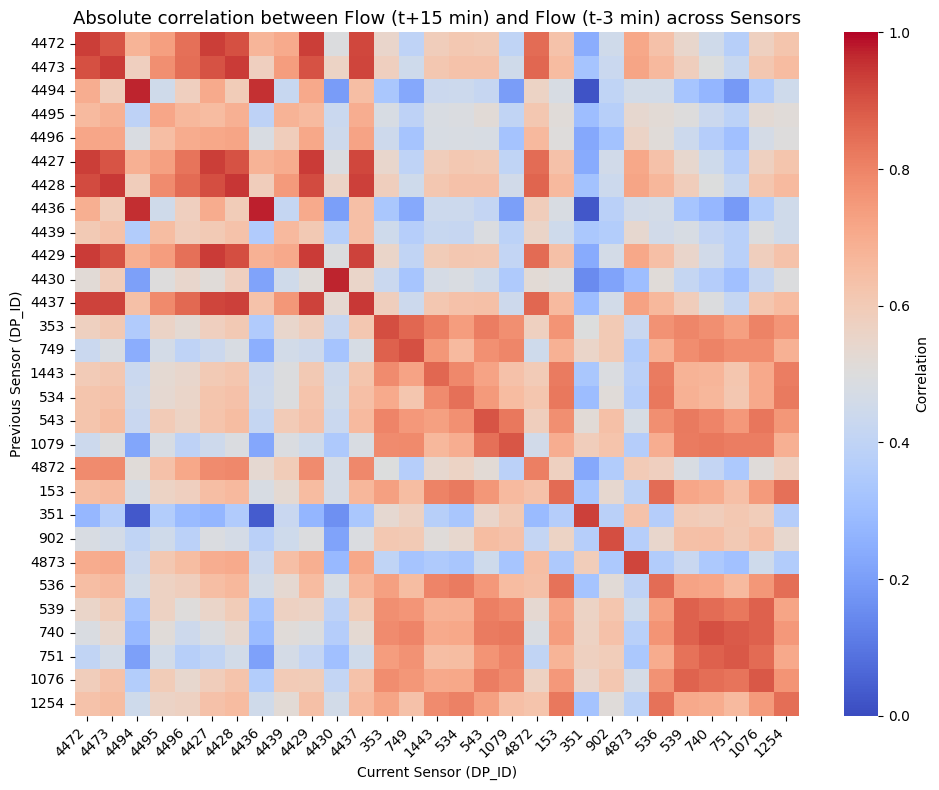

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ordered_sensors = sorted(sensor_to_portal.keys(), key=lambda x: sensor_to_portal[x])
corr_matrix = corr_matrix.loc[ordered_sensors, ordered_sensors]

plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_matrix.abs(), cmap="coolwarm", center=0.5, vmin=0, vmax=1, cbar_kws={"label": "Correlation"})
ax.set_title("Absolute correlation between Flow (t+15 min) and Flow (t-3 min) across Sensors", fontsize=13)
ax.set_xlabel("Current Sensor (DP_ID)")
ax.set_ylabel("Previous Sensor (DP_ID)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


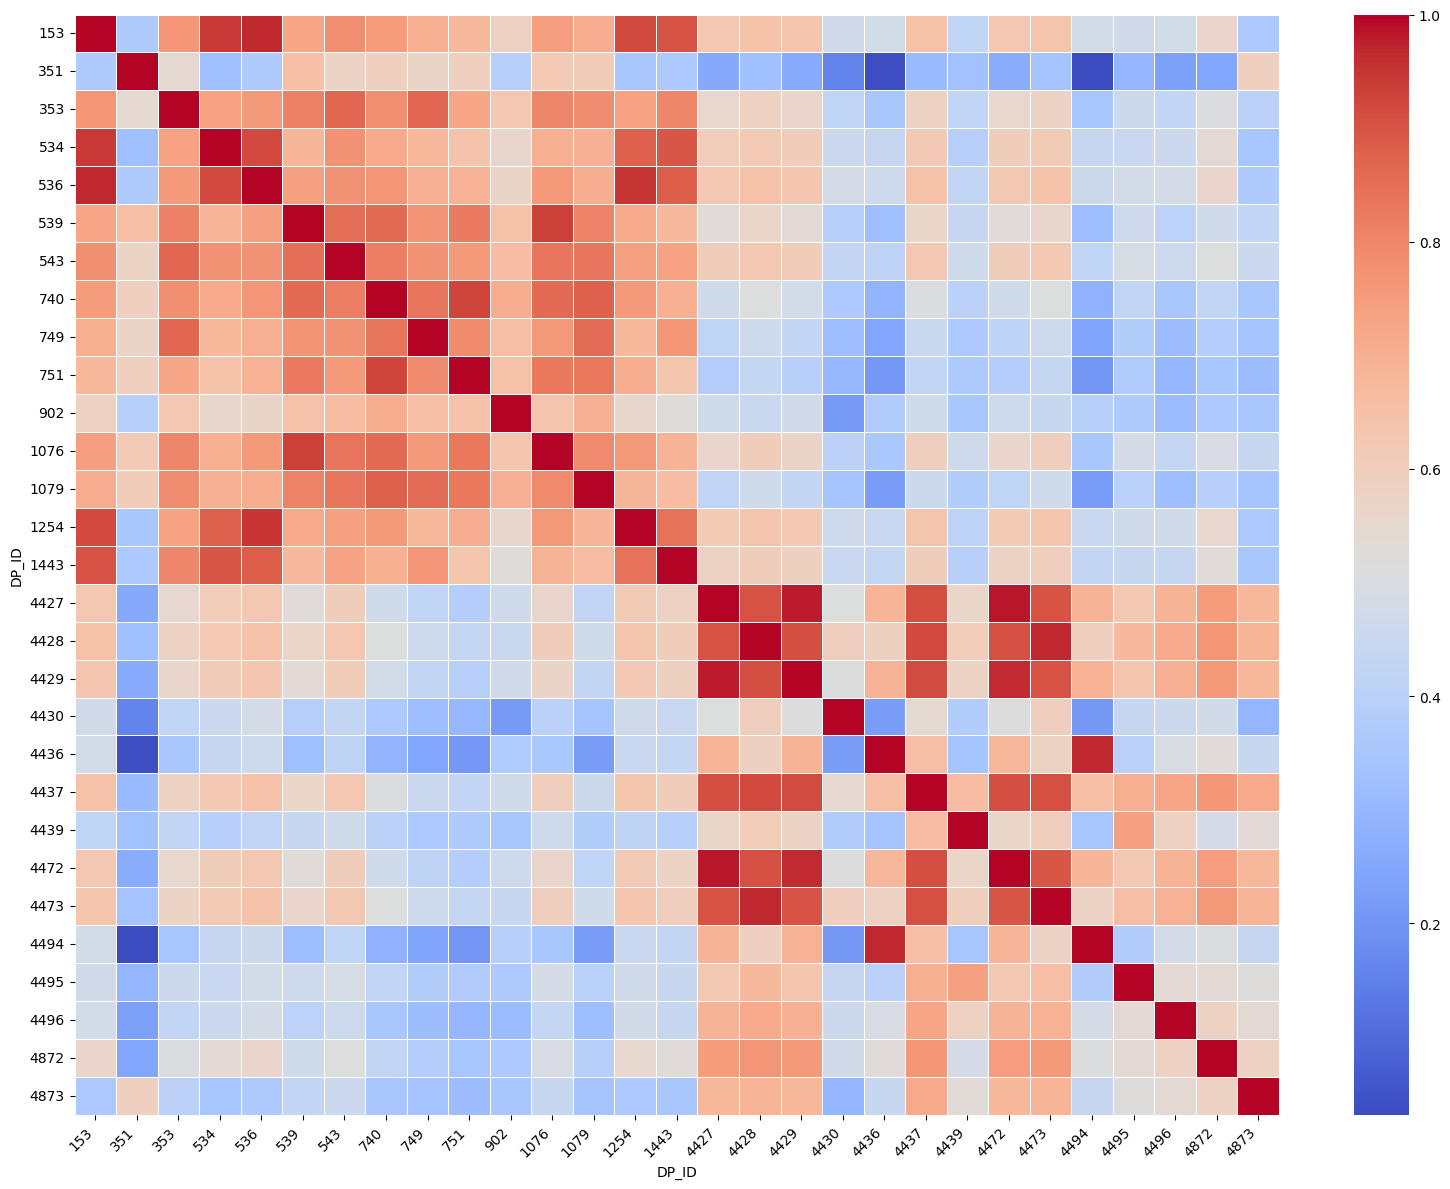

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))
ax = sns.heatmap(flow_before_wide.corr(), annot=False, cmap="coolwarm", linewidths=0.5)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()

plt.show()

#### Average Daily Traffic Flow

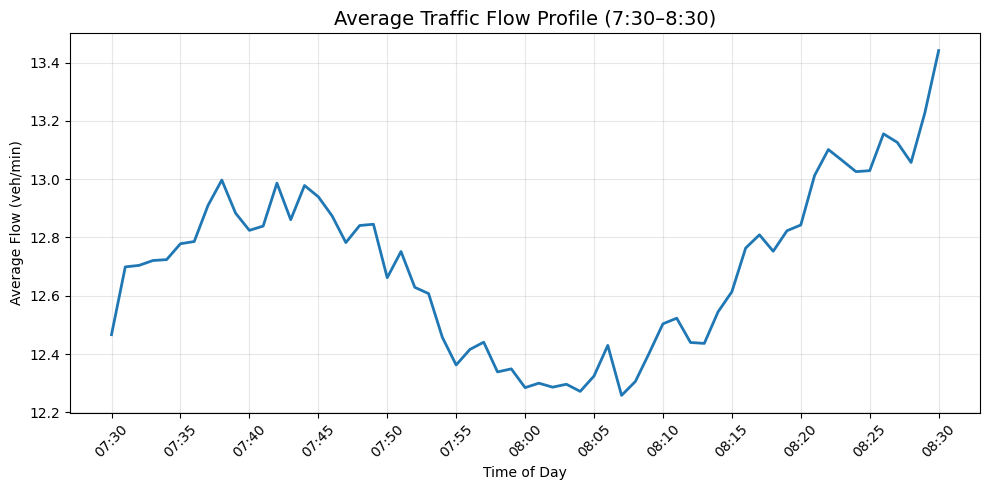

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

avg_flow = (
    train_df
    .groupby(train_df["datetime"].dt.strftime("%H:%M"))["FLOW"]
    .mean()
    .reset_index()
    .rename(columns={"datetime":"time"})
)

plt.figure(figsize=(10,5))
sns.lineplot(data=avg_flow, x="time", y="FLOW", linewidth=2)
every_n = 5
xticks = avg_flow["time"].iloc[::every_n]
plt.xticks(xticks,rotation=45)
plt.title("Average Traffic Flow Profile (7:30–8:30)", fontsize=14)
plt.xlabel("Time of Day")
plt.ylabel("Average Flow (veh/min)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



C:\Users\jemaa\AppData\Local\Temp\ipykernel_25288\3627727782.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_flow_per_sensor, x="portal_order", y="FLOW", palette="viridis")


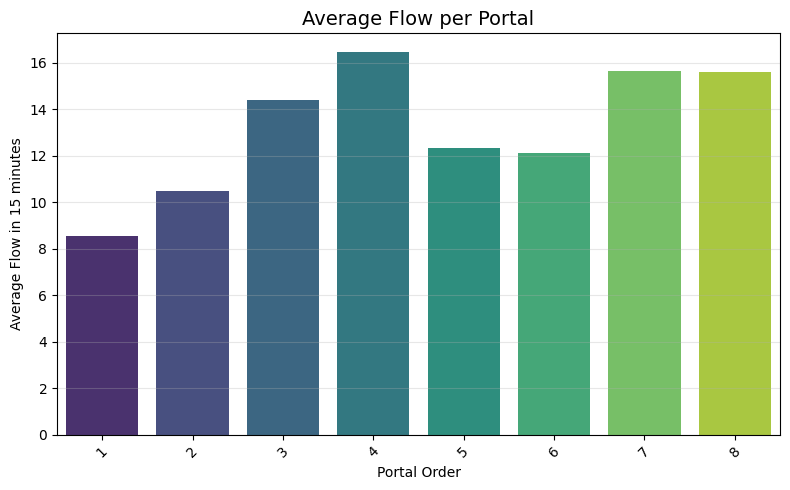

In [ ]:
mean_flow_per_sensor = (
    train_df
    .groupby("portal_order")["FLOW"]
    .mean()
    .reset_index()
    .sort_values("portal_order")
)

plt.figure(figsize=(8, 5))
sns.barplot(data=mean_flow_per_sensor, x="portal_order", y="FLOW", palette="viridis")
plt.title("Average Flow per Portal", fontsize=14)
plt.xlabel("Portal Order")
plt.ylabel("Average Flow (veh/min)")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\jemaa\AppData\Local\Temp\ipykernel_25288\1266110715.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dow_flow, x="dow", y="FLOW", palette="crest")


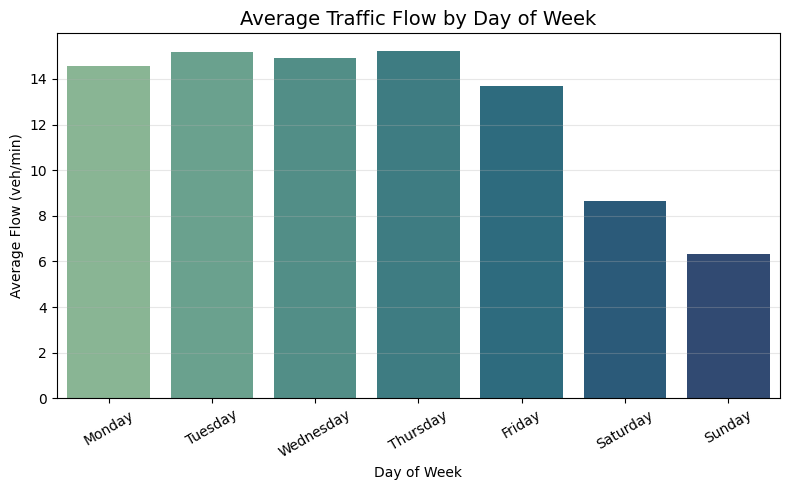

In [22]:
dow_flow = (
    train_df
    .assign(dow=train_df["datetime"].dt.day_name())
    .groupby("dow")["FLOW"]
    .mean()
    .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
    .reset_index()
)

plt.figure(figsize=(8,5))
sns.barplot(data=dow_flow, x="dow", y="FLOW", palette="crest")
plt.title("Average Traffic Flow by Day of Week", fontsize=14)
plt.xlabel("Day of Week")
plt.ylabel("Average Flow (veh/min)")
plt.xticks(rotation=30)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
